# 235 Final Project
### Team A1: Eileen Zhu, Kexin Zhou, Zijie Fang, Hongshan Lin

## Code Development

### 1. data import and preprocessing
(2 PTS)preprocessing include such tasks as imputing, binning, filtering, outlier treatment, feature engineering, text processing

In [1]:
##set up spark session
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
import pandas as pd

sc = SparkContext.getOrCreate()

import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

#### Read in Data

In [2]:
## load in data as pyspark dataframe
path_to_data=os.path.join('/home/jovyan/235FinalProject/sampleddata.csv')
df=spark.read.csv(path_to_data,header=True)

In [3]:
df.show(3)

+---------+------+--------------------+
|BrandName|Rating|             Reviews|
+---------+------+--------------------+
|  Alcatel|     1|"Phone looks good...|
|    CNPGD|     5|           excelente|
|       LG|     5|The only way you ...|
+---------+------+--------------------+
only showing top 3 rows



In [4]:
#schema of df
df.printSchema()

root
 |-- BrandName: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)



In [5]:
# check missing values
df.describe().show()
#No missing values in Price and Rating, missing values in BrandName and Reviews

+-------+--------------------+------------------+--------------------+
|summary|           BrandName|            Rating|             Reviews|
+-------+--------------------+------------------+--------------------+
|  count|               84406|            100000|               99983|
|   mean|                null|           3.82029|             12345.0|
| stddev|                null|1.5487408762872643|                 NaN|
|    min|"BlackBerry Storm...|                 1|!!!!!Update!!!!! ...|
|    max|           worryfree|                 5|                  🤗|
+-------+--------------------+------------------+--------------------+



In [6]:
#drop missing values
data=df.na.drop()
data.count()

84391

In [7]:
data.describe().show() #no missing values, total 84391 rows

+-------+--------------------+------------------+--------------------+
|summary|           BrandName|            Rating|             Reviews|
+-------+--------------------+------------------+--------------------+
|  count|               84391|             84391|               84391|
|   mean|                null|3.8177649275396663|                null|
| stddev|                null|1.5459023383844865|                null|
|    min|"BlackBerry Storm...|                 1|!!!!!Update!!!!! ...|
|    max|           worryfree|                 5|                  🤗|
+-------+--------------------+------------------+--------------------+



#### Tokenizer

In [8]:
dataset=data.select(['Rating','Reviews'])

In [9]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

Tokenize reivews:

In [10]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="Reviews", outputCol="words", pattern="\\W")
countTokens = udf(lambda words: len(words), IntegerType())

In [11]:
wordsData = tokenizer.transform(dataset)

In [12]:
wordsData.show(3)

+------+--------------------+--------------------+
|Rating|             Reviews|               words|
+------+--------------------+--------------------+
|     1|"Phone looks good...|[phone, looks, go...|
|     5|           excelente|         [excelente]|
|     5|The only way you ...|[the, only, way, ...|
+------+--------------------+--------------------+
only showing top 3 rows



Remove stop words such as a, the, etc.

In [13]:
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")

In [14]:
filteredData=stopwordsRemover.transform(wordsData)

In [15]:
filteredData.show(3)

+------+--------------------+--------------------+--------------------+
|Rating|             Reviews|               words|            filtered|
+------+--------------------+--------------------+--------------------+
|     1|"Phone looks good...|[phone, looks, go...|[phone, looks, go...|
|     5|           excelente|         [excelente]|         [excelente]|
|     5|The only way you ...|[the, only, way, ...|[way, get, pure, ...|
+------+--------------------+--------------------+--------------------+
only showing top 3 rows



Translate words into features:

In [16]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20)

In [17]:
featurizedData = hashingTF.transform(filteredData)

In [18]:
samplefeatures=featurizedData.select(['Rating','rawFeatures'])

In [19]:
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [20]:
idfModel = idf.fit(samplefeatures)

In [21]:
rescaledData = idfModel.transform(samplefeatures)

In [22]:
rescaledData.show(3)

+------+--------------------+--------------------+
|Rating|         rawFeatures|            features|
+------+--------------------+--------------------+
|     1|(20,[0,1,2,3,4,5,...|(20,[0,1,2,3,4,5,...|
|     5|      (20,[7],[1.0])|(20,[7],[0.936634...|
|     5|(20,[4,5,11,19],[...|(20,[4,5,11,19],[...|
+------+--------------------+--------------------+
only showing top 3 rows



Translate Ratings into labels:

In [23]:
labelIndexer = StringIndexer(inputCol="Rating", outputCol="label")

In [24]:
model=labelIndexer.fit(rescaledData)

In [25]:
tf=model.transform(rescaledData)

In [26]:
tf.show(3)

+------+--------------------+--------------------+-----+
|Rating|         rawFeatures|            features|label|
+------+--------------------+--------------------+-----+
|     1|(20,[0,1,2,3,4,5,...|(20,[0,1,2,3,4,5,...|  1.0|
|     5|      (20,[7],[1.0])|(20,[7],[0.936634...|  0.0|
|     5|(20,[4,5,11,19],[...|(20,[4,5,11,19],[...|  0.0|
+------+--------------------+--------------------+-----+
only showing top 3 rows



Prepare dataset(as spark dataframe) for model building:

In [27]:
input_data=tf.select('label','features')

In [28]:
input_data.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(20,[0,1,2,3,4,5,...|
|  0.0|(20,[7],[0.936634...|
|  0.0|(20,[4,5,11,19],[...|
+-----+--------------------+
only showing top 3 rows



### 2. data splitting/sampling
(1 PT)sampling may not be needed, but splitting is a must

In [29]:
(trainingData, testData) = input_data.randomSplit([0.7, 0.3],seed=88)

### 3. exploratory data analysis, with at least 2 graphs 
(2PTS)

#### Frequency Distribution for Reviews

In [30]:
#tranform df to pandas
filteredDataPanda=filteredData.select("filtered").toPandas()
#create a text file 
filteredDataPanda.to_csv('filtered_reviews.txt', index=False, sep=' ', header=None)

In [31]:
#import as rdd
review_rdd= sc.textFile('filtered_reviews.txt')
#split words
review_split = review_rdd.flatMap(lambda r: r.split("\'"))

In [32]:
#select only words
review_only = review_split.filter(lambda r: r != '') \
.filter(lambda r: r != ', ') \
.filter(lambda r: r != ']"') \
.filter(lambda r: r != '"[') \
.filter(lambda r: r != '[') \
.filter(lambda r: r != ']')

In [33]:
review_words_count = review_only.map(lambda x: (x, 1)) \
.reduceByKey(lambda x,y:x+y) \
.map(lambda x: (x[1], x[0])) \
.sortByKey(False)

review_words_count.take(10)

[(87378, 'phone'),
 (20943, 'great'),
 (19954, 'good'),
 (12732, 'one'),
 (11559, 'like'),
 (11286, 'screen'),
 (11055, 'use'),
 (10739, 'battery'),
 (9926, 'works'),
 (9370, 'love')]

#### Word Cloud for Reviews

In [34]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
f = open('filtered_reviews.txt','r',encoding='utf-8').read()
from nltk.tokenize import word_tokenize 
  
word_tokens = word_tokenize(f) 
stop_words=list(nltk.corpus.stopwords.words('english')) 
# Add "phone" to the stop words dictionary
stop_words.append("phone")

filtered_sentence = [w for w in word_tokens if not w in stop_words] 

wl_space_split = " ".join(filtered_sentence)

In [36]:
from pyspark.sql import SparkSession
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#create wordcloud
review_wc = WordCloud(
        background_color="white",
        width=1500,             
        height=960,              
        margin=10               
        ).generate(wl_space_split)
plt.figure()
plt.imshow(review_wc)
plt.axis("off")
plt.show()
review_wc.to_file('review_wc.png')

<Figure size 640x480 with 1 Axes>

#### Sentiment Words Analysis

In [37]:
import pyspark.sql.functions as F

In [38]:
gooddict = ["good","great","nice","wonderful","best","perfect","fantastic","greatest",
            "love","like","awesome","thank","amazing","recommend"]
baddict = ["bad","worse","worst","terrible","never","fake","not","problem","slow","returned",
           "disappointed","complaint","issue"]

In [39]:
def Sentiment(word_dict,data_rdd):
    count = []
    for w in word_dict:
        wordcount = data_rdd.filter(lambda r: w in r).count()
        count.append(wordcount)
    sentiment = pd.DataFrame(index=word_dict, columns=['wordCount'], data=count)
    sentiment.sort_values(by='wordCount', ascending=False, inplace=True)
    return sentiment.head(10)

In [40]:
# top 10 most frequently used positive words
Sentiment(gooddict, review_only)

wordCount
great          21310
good           20170
like           13156
love           11966
perfect         6033
nice            5947
recommend       4332
best            3831
thank           3538
amazing         2437

In [41]:
# top 10 most frequently used negative words
Sentiment(baddict, review_only)

wordCount
not                7712
problem            7228
issue              4387
never              3089
bad                2952
slow               2063
disappointed       1601
complaint          1053
returned           1032
terrible            681

#### Brand Rating Analysis

In [42]:
#distinct brand count
#total 315 brands
print('rows={}'.format(data.select('BrandName').distinct().count()))

rows=315


In [43]:
#distribution of Brand reviews
brandcount=data.groupBy("BrandName").count() \
        .orderBy(col("count").desc())
brandcount.show(5)

+----------+-----+
| BrandName|count|
+----------+-----+
|   Samsung|16002|
|       BLU|15250|
|     Apple|14324|
|        LG| 5424|
|BlackBerry| 4028|
+----------+-----+
only showing top 5 rows



In [44]:
#comput average rating for each brand 
avgRating=data.groupBy("BrandName").agg(F.mean('Rating'))
avgRating.sort("avg(Rating)",ascending=False,inplace=True).show(5)

+--------------------+-----------+
|           BrandName|avg(Rating)|
+--------------------+-----------+
|samsung galaxy in...|        5.0|
|           Quick-get|        5.0|
|Seawolf Technologies|        5.0|
|           microsoft|        5.0|
|             Getnord|        5.0|
+--------------------+-----------+
only showing top 5 rows



In [45]:
#rate count for each brand
br=data.select(['BrandName','Rating'])
ratecount=br.groupBy("BrandName").count()\
            .orderBy(col("count").desc())\
            .selectExpr("BrandName as BrandName","count as ratecount")
ratecount.show(5)

+----------+---------+
| BrandName|ratecount|
+----------+---------+
|   Samsung|    16002|
|       BLU|    15250|
|     Apple|    14324|
|        LG|     5424|
|BlackBerry|     4028|
+----------+---------+
only showing top 5 rows



#### 5-Star Rate for Each Brand

In [46]:
# 5-star rate count for each brand
rate5starcount=br.filter(df["Rating"]==5)\
                .groupBy("BrandName").count()\
                .orderBy(col("count").desc())\
                .selectExpr("BrandName as BrandName","count as 5starratecount")
rate5starcount.show(5)

+----------+--------------+
| BrandName|5starratecount|
+----------+--------------+
|   Samsung|          9385|
|     Apple|          8783|
|       BLU|          7597|
|        LG|          2948|
|BlackBerry|          2141|
+----------+--------------+
only showing top 5 rows



In [47]:
#join all dataframes
data2=brandcount.join(avgRating,["BrandName"]).join(ratecount,["BrandName"]).join(rate5starcount,["BrandName"])

In [48]:
#compute 5-star rate count for each brand name
data3=data2.withColumn('5StarPercent',F.col('5starratecount')/F.col('ratecount')).sort("count",ascending=False,inplace=True)
data3.show(5)

+----------+-----+------------------+---------+--------------+------------------+
| BrandName|count|       avg(Rating)|ratecount|5starratecount|      5StarPercent|
+----------+-----+------------------+---------+--------------+------------------+
|   Samsung|16002| 3.973065866766654|    16002|          9385|0.5864891888513936|
|       BLU|15250| 3.787213114754098|    15250|          7597|0.4981639344262295|
|     Apple|14324|3.9247416922647305|    14324|          8783|0.6131667132086009|
|        LG| 5424| 3.840523598820059|     5424|          2948|0.5435103244837758|
|BlackBerry| 4028| 3.743296921549156|     4028|          2141|0.5315292949354519|
+----------+-----+------------------+---------+--------------+------------------+
only showing top 5 rows



#### Word Cloud for Brands Based on 5-Star Rate

In [49]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [50]:
# Select only "BrandName" and its frequencies
five_star_rate=data3.select("BrandName","5StarPercent").sort("5StarPercent",ascending=False,inplace=True)
# Transform df to list
frequencies = five_star_rate.toPandas().set_index('BrandName').T.to_dict('records')

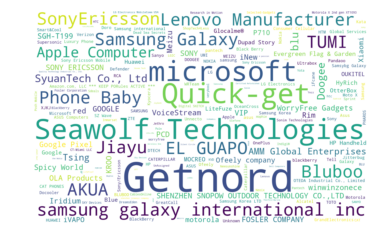

In [51]:
five_star_rate_wc = WordCloud(
        background_color="white", 
        width=1500,              
        height=960,              
        margin=10               
        ).generate_from_frequencies(dict(*frequencies))
plt.figure()
plt.imshow(five_star_rate_wc, interpolation="bilinear")
plt.axis("off")
plt.show()
# Save Image
five_star_rate_wc.to_file('five_star_rate_wc.png') 

#### Brand Distribution & Average Rating

In [52]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [53]:
top20=data3.collect()[0:20]
Brands = [i[0] for i in top20]
counts = [i[1] for i in top20]
ratingavg=[i[2] for i in top20]
starpercentage=[i[5] for i in top20]
ind = np.array(range(len(top20)))
width = 0.35

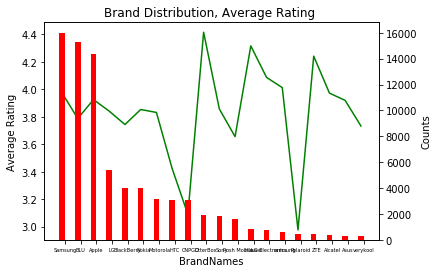

In [54]:
fig, ax1 = plt.subplots()
#plot first graph
plt.plot(ind, ratingavg, color='g')
plt.xticks(ind + width/2., Brands,fontsize=5)
plt.xlabel('BrandNames')
plt.ylabel('Average Rating')
plt.title('Brand Distribution, Average Rating ')

ax2 = ax1.twinx()
#plot second graph
plt.bar(ind, counts, width=width, color='r')
plt.ylabel('Counts')
plt.xlabel('Brand Names')
plt.xticks(ind + width/2., Brands,fontsize=5)

plt.show()

#### Word Cloud for Samsung

In [55]:
reviewSamsung=data.filter(data["BrandName"]=="Samsung")

In [56]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Reviews", outputCol="words", pattern="\\W")
# stop words
stop_words=list(nltk.corpus.stopwords.words('english')) 

In [57]:
# Add "phone" to the stop words dictionary
stop_words.append("phone")

In [58]:
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered",stopWords=stop_words)

In [59]:
#tokenize Samsung reivews
pipelinerate=Pipeline(stages=[regexTokenizer,stopwordsRemover])
pipelineratefit=pipelinerate.fit(reviewSamsung)
datasetReview=pipelineratefit.transform(reviewSamsung)
datasetReview.show(5)

+---------+------+--------------------+--------------------+--------------------+
|BrandName|Rating|             Reviews|               words|            filtered|
+---------+------+--------------------+--------------------+--------------------+
|  Samsung|     5|I bought this as ...|[i, bought, this,...|[bought, travel, ...|
|  Samsung|     4|This is a great p...|[this, is, a, gre...|[great, easy, set...|
|  Samsung|     5|Great phone with ...|[great, phone, wi...|[great, fantastic...|
|  Samsung|     5|       Great Product|    [great, product]|    [great, product]|
|  Samsung|     5|i bought this as ...|[i, bought, this,...|[bought, gift, so...|
+---------+------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [60]:
datasetPanda=datasetReview.select("filtered").toPandas()
#create a text file 
datasetPanda.to_csv('Samsung.txt', index=False, sep=' ', header=None)

In [61]:
f = open('Samsung.txt','r',encoding='utf-8').read()
from nltk.tokenize import word_tokenize 
  
word_tokens = word_tokenize(f) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 

wl_space_split = " ".join(filtered_sentence)

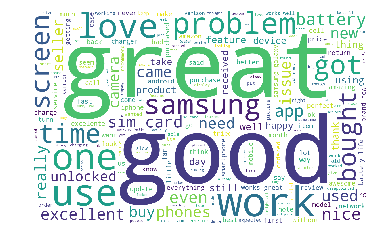

In [62]:
wordcloud = WordCloud(
        background_color="white", 
        width=1500,              
        height=960,              
        margin=10              
        ).generate(wl_space_split)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('Samsung_wc.png')

### 4. model construction, with at least 3 models
(3PTS) ideally the models are constructed using pipelines

A complete project will consider at least 2 models:

1.  A benchmark model, which is relatively simple.  This could be a regression model with a small number of features (possibly a single feature).  This provides a basis for comparison and a sanity check.
2. A more sophisticated model, which could be one of the models covered in class.  The best model found in your experiments is called the champion model.

The model construction process should follow the best practices covered in class, including:

a.	Data preprocessing.  The required steps will depend on the model, and could include:

	i. dummy variable construction
	ii. feature scaling
 	iii. handling missing values and outliers
	iv. handling semi-structured / unstructured data
	v. dimensionality reduction (e.g., PCA)

b.	Data splitting (train/validation/test sets, for example).  The test set should be left out for evaluation purposes.  It should NOT be used in training.
c.	K-fold cross validation of hyperparameters


#### Lasso Regression

#### Logistic Regression

#### KNN


#### Random Forest

In [63]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [64]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)

In [65]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 5 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(input_data)

In [66]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

In [67]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [68]:
# Chain indexers and forest in a Pipeline
rfpipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [69]:
# Train model.  This also runs the indexers.
rftrainedmodel = rfpipeline.fit(trainingData)

In [70]:
# Make predictions.
rfpredictions = rftrainedmodel.transform(testData)

In [71]:
# Select (prediction, true label) and compute test error
rfevaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

In [72]:
rfaccuracy = rfevaluator.evaluate(rfpredictions)
print("Test Error = %g" % (1.0 - rfaccuracy))

Test Error = 0.458378


In [73]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
rfresults = rfpredictions.select(['probability', 'label'])

In [74]:
## prepare score-label set
rfresults_collect = rfresults.collect()
rfresults_list = [(float(i[0][0]), 1.0-float(i[1])) for i in rfresults_collect]
rfscoreAndLabels = sc.parallelize(rfresults_list)

rfmetrics = metric(rfscoreAndLabels)
print("The ROC score is (@numTrees=10): ", rfmetrics.areaUnderROC)
print("The Precision score is (@numTrees=10): ", rfmetrics.areaUnderPR)

The ROC score is (@numTrees=10):  0.6952904637275329
The Precision score is (@numTrees=10):  0.7120444666759944


#### Decision Tree

In [75]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
dtpipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
dtmodel = dtpipeline.fit(trainingData)

# Make predictions.
dtpredictions = dtmodel.transform(testData)

In [76]:
# Select (prediction, true label) and compute test error
dtevaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
dtaccuracy = dtevaluator.evaluate(dtpredictions)
print("Test Error = %g " % (1.0 - dtaccuracy))

Test Error = 0.451742 


In [77]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [78]:
evaluatortest=BinaryClassificationEvaluator()
evaluatortest.evaluate(dtpredictions)

0.37266136513392356

In [79]:
model.stages[-1]

AttributeError: 'StringIndexerModel' object has no attribute 'stages'

In [ ]:
#画不出树来QAQ怎么办！
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.util import MLUtils
data = MLUtils.loadLibSVMFile(sc,'/home/jovyan/235FinalProject/sampleddata.csv').cache()
# Load and parse the data file into an RDD of LabeledPoint.
# Cache the data since we will use it again to compute training error.

# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(input_data, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=100)

# Evaluate model on training instances and compute training error
predictions = model.predict(input_data.map(lambda x: x.features))
labelsAndPredictions = input_data.map((lambda lp: lp.label).zip(predictions))
trainErr = labelsAndPredictions.filter(lambda seq: seq[0] != seq[1]).count() / float(input_data.count())
print('Training Error = ' + str(trainErr))
print('Learned classification tree model:')
print(model)

#### Naive Bayes （是不是要用pipeline？？？）

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# Split the data into train and test
splits = input_data.randomSplit([0.7, 0.3], 1234)
train = splits[0]
test = splits[1]

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
model = nb.fit(train)

# select example rows to display.
predictions = model.transform(test)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")

In [ ]:
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

In [ ]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, pred)
print('F score is:',f1)